In [11]:
import sys
from sys import platform
import matplotlib.pyplot as plt
from matplotlib.ticker import ScalarFormatter
from matplotlib.gridspec import GridSpec
import copy
import matplotlib as mpl
mpl.rcParams['agg.path.chunksize'] = 10000

import numpy as np
import pickle
import seaborn as sns
from scipy.interpolate import interp1d
from scipy.integrate import quad
from IPython.display import display, Math
from tqdm import tqdm

from astropy.io import fits, ascii
from astropy.table import Table
from astropy.modeling import functional_models, fitting
from astropy.timeseries import LombScargle

sns.set_context('paper')
sns.set(font_scale=1.3)
sns.set_style("darkgrid")
sns.set_style({'axes.edgecolor': 'black'})
# sns.set_style("ticks")
sns.set_palette("colorblind")

sys.path.insert(1, '/Users/sean/scripts/helpers')
root_dir = '/Volumes/Samsung_1TB/AstroData/MAXI_J0655m013/'

nustar_obs1 = [5.975194215490741E+04, 5.975194215490741E+04 + (8.186399999976158E+04/(3600*24))]
nustar_obs2 = [5.980585043905106E+04, 5.980585043905106E+04 + (4.208824998831749E+04/(3600*24))]



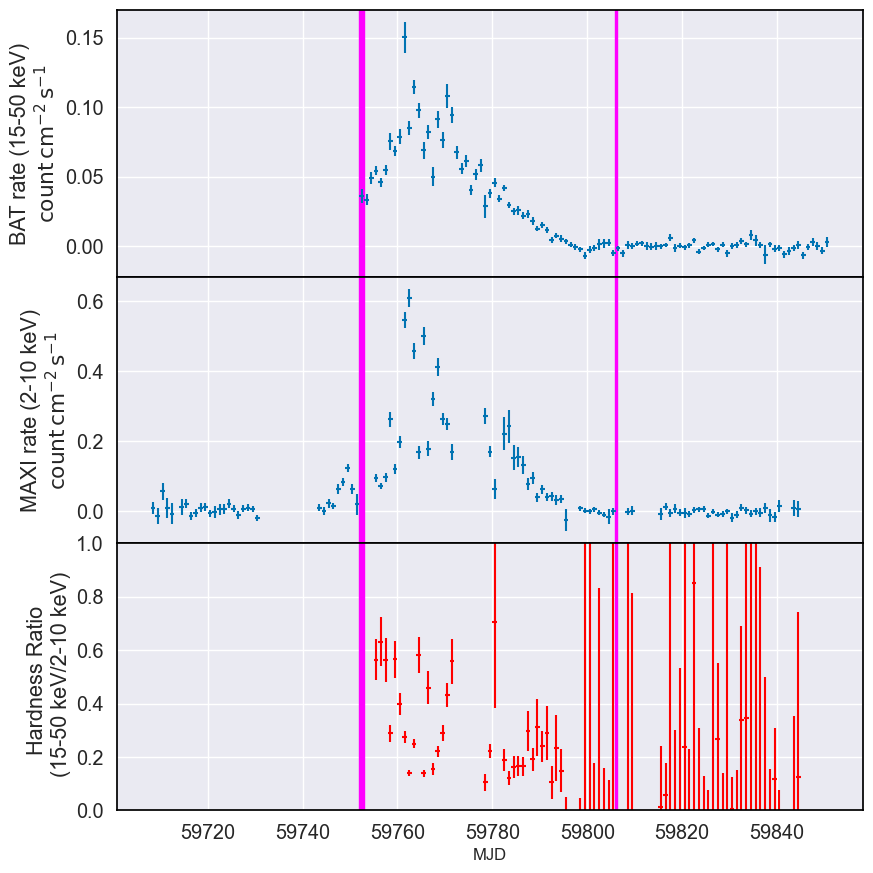

In [2]:
bat_lc = fits.open(root_dir + 'MAXI/MAXIJ0655-013.lc.fits')[1].data
maxi_lc = ascii.read(root_dir + 'MAXI/J0655-014_g_lc_1day_all.dat', names = ['MJD', 'rate 2-20keV', 'err 2-20keV', \
                                                                             'rate 2-4keV', 'err 2-4keV', \
                                                                             'rate 4-10keV', 'err 4-10keV', \
                                                                             'rate 10-20keV', 'err 10-20keV'])


fig, axes = plt.subplots(3, 1, figsize = (9, 9), gridspec_kw={'hspace':0}, sharex=True)
hard = maxi_lc['rate 10-20keV'] 
hard_err = maxi_lc['err 10-20keV']
soft = maxi_lc['rate 2-4keV'] + maxi_lc['rate 4-10keV']
soft_err = np.sqrt(np.square(maxi_lc['err 2-4keV']) + np.square(maxi_lc['err 4-10keV']))

maxi_mask = [day in bat_lc['TIME']+0.5 for day in maxi_lc['MJD']]
bat_mask = [day in maxi_lc['MJD']-0.5 for day in bat_lc['TIME']]
# print(bat_lc['TIME'])
# print(maxi_lc['MJD'])
# print(maxi_mask)
# print(bat_mask)

hardness = bat_lc['RATE'][bat_mask]/soft[maxi_mask]
hardness_err = hardness*np.sqrt(np.square(bat_lc['ERROR'][bat_mask]/bat_lc['RATE'][bat_mask]) + np.square(soft_err[maxi_mask]/soft[maxi_mask]))

axes[0].errorbar(bat_lc['TIME'] + 0.5, bat_lc['RATE'], xerr= 0.5, yerr=bat_lc['ERROR'], fmt='', ls='')
axes[1].errorbar(maxi_lc['MJD'], soft, xerr= 0.5, yerr=soft_err, fmt='', ls='')
axes[2].errorbar(maxi_lc['MJD'][maxi_mask], hardness, xerr= 0.5, yerr=hardness_err, fmt='', ls='', color='red')
axes[2].set_ylim(0, 1)

for ax in axes:
    ax.axvspan(nustar_obs1[0], nustar_obs1[1], color= 'magenta')
    ax.axvspan(nustar_obs2[0], nustar_obs2[1], color= 'magenta')

axes[0].set_ylabel('BAT rate (15-50 keV)\n' + r'$\mathrm{count\,cm^{-2}\,s^{-1}}$')   
axes[1].set_ylabel('MAXI rate (2-10 keV)\n' + r'$\mathrm{count\,cm^{-2}\,s^{-1}}$')  
axes[2].set_ylabel('Hardness Ratio \n (15-50 keV/2-10 keV)')    
                 
# axes[0].annotate('Swift BAT 15-150 keV', xy=(0.6, 0.75), xycoords='axes fraction', fontsize=14)
# axes[1].annotate('MAXI 2-20 keV', xy=(0.6, 0.75), xycoords='axes fraction', fontsize=14)
# axes[2].annotate('MAXI 2-4 keV', xy=(0.6, 0.75), xycoords='axes fraction', fontsize=14)
# axes[3].annotate('MAXI 4-10 keV', xy=(0.6, 0.75), xycoords='axes fraction', fontsize=14)
# axes[4].annotate('MAXI 10-20 keV', xy=(0.6, 0.75), xycoords='axes fraction', fontsize=14)
# axes[5].annotate('MAXI HR', xy=(0.6, 0.75), xycoords='axes fraction', fontsize=14)

axes[2].set_xlabel('MJD', fontsize=12)
plt.tight_layout()
plt.savefig(root_dir + 'figures/BAT_MAXI_hardness_day.pdf')


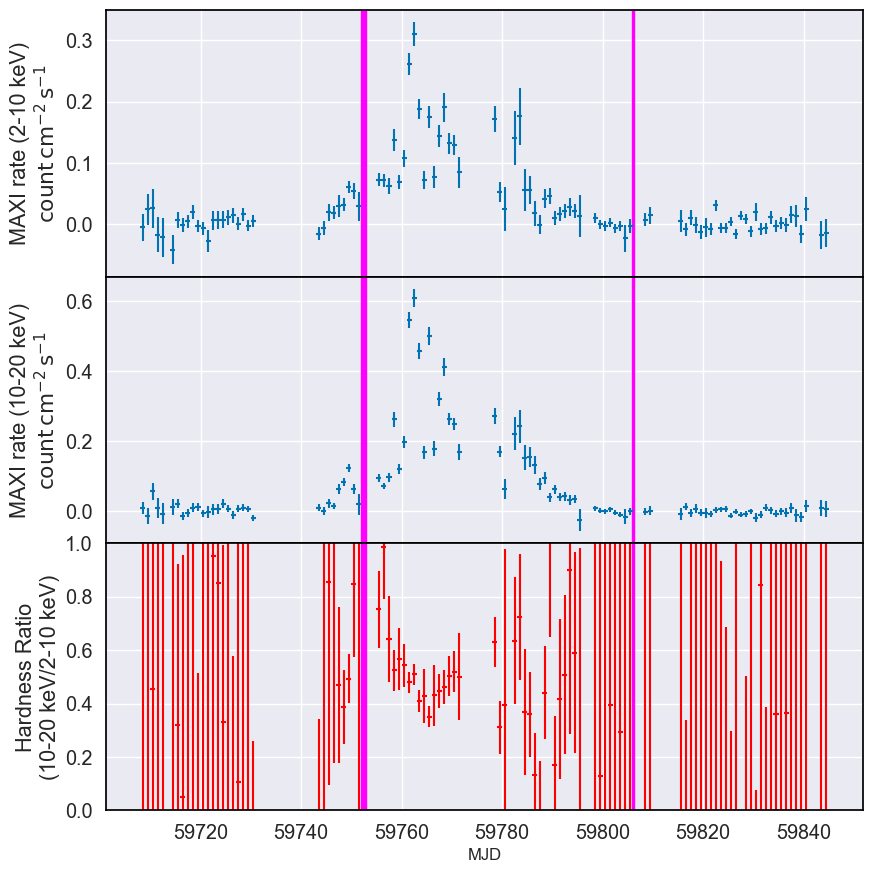

In [3]:
maxi_lc = ascii.read(root_dir + 'MAXI/J0655-014_g_lc_1day_all.dat', names = ['MJD', 'rate 2-20keV', 'err 2-20keV', \
                                                                             'rate 2-4keV', 'err 2-4keV', \
                                                                             'rate 4-10keV', 'err 4-10keV', \
                                                                             'rate 10-20keV', 'err 10-20keV'])


fig, axes = plt.subplots(3, 1, figsize = (9, 9), gridspec_kw={'hspace':0}, sharex=True)
hard = maxi_lc['rate 10-20keV'] 
hard_err = maxi_lc['err 10-20keV']
soft = maxi_lc['rate 2-4keV'] + maxi_lc['rate 4-10keV']
soft_err = np.sqrt(np.square(maxi_lc['err 2-4keV']) + np.square(maxi_lc['err 4-10keV']))

# print(bat_lc['TIME'])
# print(maxi_lc['MJD'])
# print(maxi_mask)
# print(bat_mask)

hardness = hard/soft
hardness_err = hardness*np.sqrt(np.square(hard_err/hard) + np.square(soft_err/soft))

axes[0].errorbar(maxi_lc['MJD'], hard, xerr= 0.5, yerr=hard_err, fmt='', ls='')
axes[1].errorbar(maxi_lc['MJD'], soft, xerr= 0.5, yerr=soft_err, fmt='', ls='')
axes[2].errorbar(maxi_lc['MJD'], hardness, xerr= 0.5, yerr=hardness_err, fmt='', ls='', color='red')
axes[2].set_ylim(0, 1)

for ax in axes:
    ax.axvspan(nustar_obs1[0], nustar_obs1[1], color= 'magenta')
    ax.axvspan(nustar_obs2[0], nustar_obs2[1], color= 'magenta')

axes[0].set_ylabel('MAXI rate (2-10 keV)\n' + r'$\mathrm{count\,cm^{-2}\,s^{-1}}$')   
axes[1].set_ylabel('MAXI rate (10-20 keV)\n' + r'$\mathrm{count\,cm^{-2}\,s^{-1}}$')  
axes[2].set_ylabel('Hardness Ratio\n(10-20 keV/2-10 keV)')    
                 
# axes[0].annotate('Swift BAT 15-150 keV', xy=(0.6, 0.75), xycoords='axes fraction', fontsize=14)
# axes[1].annotate('MAXI 2-20 keV', xy=(0.6, 0.75), xycoords='axes fraction', fontsize=14)
# axes[2].annotate('MAXI 2-4 keV', xy=(0.6, 0.75), xycoords='axes fraction', fontsize=14)
# axes[3].annotate('MAXI 4-10 keV', xy=(0.6, 0.75), xycoords='axes fraction', fontsize=14)
# axes[4].annotate('MAXI 10-20 keV', xy=(0.6, 0.75), xycoords='axes fraction', fontsize=14)
# axes[5].annotate('MAXI HR', xy=(0.6, 0.75), xycoords='axes fraction', fontsize=14)

axes[2].set_xlabel('MJD', fontsize=12)
plt.tight_layout()
plt.savefig(root_dir + 'figures/MAXI_hardness_day.pdf')


In [4]:
maxi_lc = ascii.read(root_dir + 'MAXI/J0655-014_g_lc_1orb_all.dat', names = ['MJD', 'rate 2-20keV', 'err 2-20keV', \
                                                                             'rate 2-4keV', 'err 2-4keV', \
                                                                             'rate 4-10keV', 'err 4-10keV', \
                                                                             'rate 10-20keV', 'err 10-20keV'])

time = np.arange(59708.218750, 59844.218750 + 3/(2*24),3/(2*24))
hard = []
hard_err = []
soft = []
soft_err = []
hardness = []
hardness_err = []

for t in time:
    if t in maxi_lc['MJD']:
        i = np.argwhere(maxi_lc['MJD']==t)
        hard.append(maxi_lc['rate 10-20keV'][i])
        hard_err.append(maxi_lc['err 10-20keV'][i])
        soft.append(maxi_lc['rate 2-4keV'][i] + maxi_lc['rate 4-10keV'][i])
        soft_err.append(np.sqrt(np.square(maxi_lc['err 2-4keV'][i]) + np.square(maxi_lc['err 4-10keV'][i])))
        temp_hardness = maxi_lc['rate 10-20keV'][i]/(maxi_lc['rate 2-4keV'][i] + maxi_lc['rate 4-10keV'][i])
        hardness.append(temp_hardness)
        hardness_err.append(temp_hardness*np.sqrt(np.square(maxi_lc['err 10-20keV'][i]/maxi_lc['rate 10-20keV'][i]) + \
                                                  np.square(np.sqrt(np.square(maxi_lc['err 2-4keV'][i]) + \
                                                                    np.square(maxi_lc['err 4-10keV'][i]))/\
                                                            (maxi_lc['rate 2-4keV'][i] + maxi_lc['rate 4-10keV'][i]))))
    else:
        hard.append(np.inf)
        hard_err.append(np.inf)
        soft.append(np.inf)
        soft_err.append(np.inf)
        hardness.append(np.inf)
        hardness_err.append(np.inf)
        
hard = np.array(hard, dtype=float)
hard_err = np.array(hard_err, dtype=float)
soft = np.array(soft, dtype=float)
soft_err = np.array(soft_err, dtype=float)
hardness = np.array(hardness, dtype=float)
hardness_err = np.array(hardness_err, dtype=float)

time_mask = (hard != np.inf)
print(time_mask)

moving_hardness = moving_average(hardness, 5)
moving_mask = (moving_hardness != np.inf)

fig, axes = plt.subplots(3, 1, figsize = (27, 9), gridspec_kw={'hspace':0}, sharex=True)

axes[0].errorbar(time[time_mask], hard[time_mask], xerr= 3/(24*4), yerr=hard_err[time_mask], fmt='', ls='', lw=0.5)
axes[1].errorbar(time[time_mask], soft[time_mask], xerr= 3/(24*4), yerr=soft_err[time_mask], fmt='', ls='', lw=0.5)
axes[2].errorbar(time[time_mask], hardness[time_mask], xerr= 3/(24*4), yerr=hardness_err[time_mask], fmt='', ls='', color='C1', lw=0.5)
axes[2].plot(time[moving_mask], moving_hardness[moving_mask], color='C2')
axes[2].set_ylim(0, 2)
# axes[2].set_xlim(59758, 59771)

for ax in axes:
    ax.axvspan(nustar_obs1[0], nustar_obs1[1], color= 'magenta')
    ax.axvspan(nustar_obs2[0], nustar_obs2[1], color= 'magenta')

axes[0].set_ylabel('MAXI count rate (10-20 keV)\n' + r'$\mathrm{count\,cm^{-2}\,s^{-1}}$')   
axes[1].set_ylabel('MAXI count rate (2-10 keV)\n' + r'$\mathrm{count\,cm^{-2}\,s^{-1}}$')  
axes[2].set_ylabel('Hardness Ratio \n (10-20 keV/2-10 keV)')    
                 
# axes[0].annotate('Swift BAT 15-150 keV', xy=(0.6, 0.75), xycoords='axes fraction', fontsize=14)
# axes[1].annotate('MAXI 2-20 keV', xy=(0.6, 0.75), xycoords='axes fraction', fontsize=14)
# axes[2].annotate('MAXI 2-4 keV', xy=(0.6, 0.75), xycoords='axes fraction', fontsize=14)
# axes[3].annotate('MAXI 4-10 keV', xy=(0.6, 0.75), xycoords='axes fraction', fontsize=14)
# axes[4].annotate('MAXI 10-20 keV', xy=(0.6, 0.75), xycoords='axes fraction', fontsize=14)
# axes[5].annotate('MAXI HR', xy=(0.6, 0.75), xycoords='axes fraction', fontsize=14)

axes[2].set_xlabel('MJD', fontsize=12)
plt.savefig(root_dir + 'figures/MAXI_hardness_orb.pdf')


/var/folders/hn/57rl92351t9cnxl3dzdym3400000gn/T/ipykernel_81866/3123401235.py:23: RuntimeWarning: divide by zero encountered in true_divide
  hardness_err.append(temp_hardness*np.sqrt(np.square(maxi_lc['err 10-20keV'][i]/maxi_lc['rate 10-20keV'][i]) + \
/var/folders/hn/57rl92351t9cnxl3dzdym3400000gn/T/ipykernel_81866/3123401235.py:23: RuntimeWarning: invalid value encountered in multiply
  hardness_err.append(temp_hardness*np.sqrt(np.square(maxi_lc['err 10-20keV'][i]/maxi_lc['rate 10-20keV'][i]) + \
/var/folders/hn/57rl92351t9cnxl3dzdym3400000gn/T/ipykernel_81866/3123401235.py:35: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  hard = np.array(hard, dtype=float)
/var/folders/hn/57rl92351t9cnxl3dzdym3400000gn/T/ipykernel_81866/3123401235.py:36: De

[ True  True False ...  True  True  True]


NameError: name 'moving_average' is not defined

# Pulse-corrected lightcurve

In [15]:
pulsations = ascii.read(root_dir + 'pulse_history.txt', delimiter= ',')
raw_lc = fits.open(root_dir + 'MAXI_J0655-013_lc/MAXI_J0655-013_gsc.flc')[1].data
lc_starts = 59740.02427083 + (raw_lc['START'] - raw_lc['START'][0])/(3600*24)
lc_stops = 59740.02427083 + (raw_lc['STOP'] - raw_lc['START'][0])/(3600*24)
lc_MJD = (lc_starts + lc_stops)/2.
lc_MJD_err = (lc_stops - lc_starts)/2.

In [25]:
# pulse_interp = interp1d(pulsations['MJD'], pulsations['PROFILE'])
interp_mask = (lc_starts > pulsations['MJD'][0]) & (lc_stops < pulsations['MJD'][-1])
lc_pulse_corr = np.array([np.mean(pulsations['PROFILE'][(pulsations['MJD'] <= lc_stops[interp_mask][i]) & (pulsations['MJD'] >= lc_starts[interp_mask][i])]) for i in range(len(lc_starts[interp_mask]))])

In [27]:
print(np.max(lc_pulse_corr))

1.756962730100078


<ErrorbarContainer object of 3 artists>

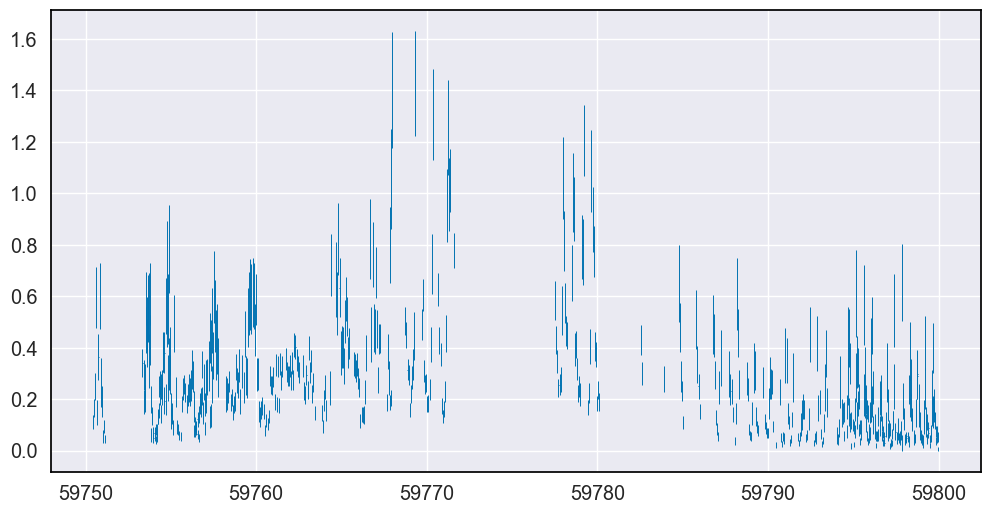

In [38]:
plt.figure(figsize=(12,6))
plt.errorbar(lc_MJD[interp_mask], (raw_lc['SCOUNT1']/raw_lc['EXPOSURE'])[interp_mask]/lc_pulse_corr, yerr = (np.sqrt(raw_lc['SCOUNT1'])/raw_lc['EXPOSURE'])[interp_mask]/lc_pulse_corr, xerr= lc_MJD_err[interp_mask], fmt='', ls='', lw=0.7)

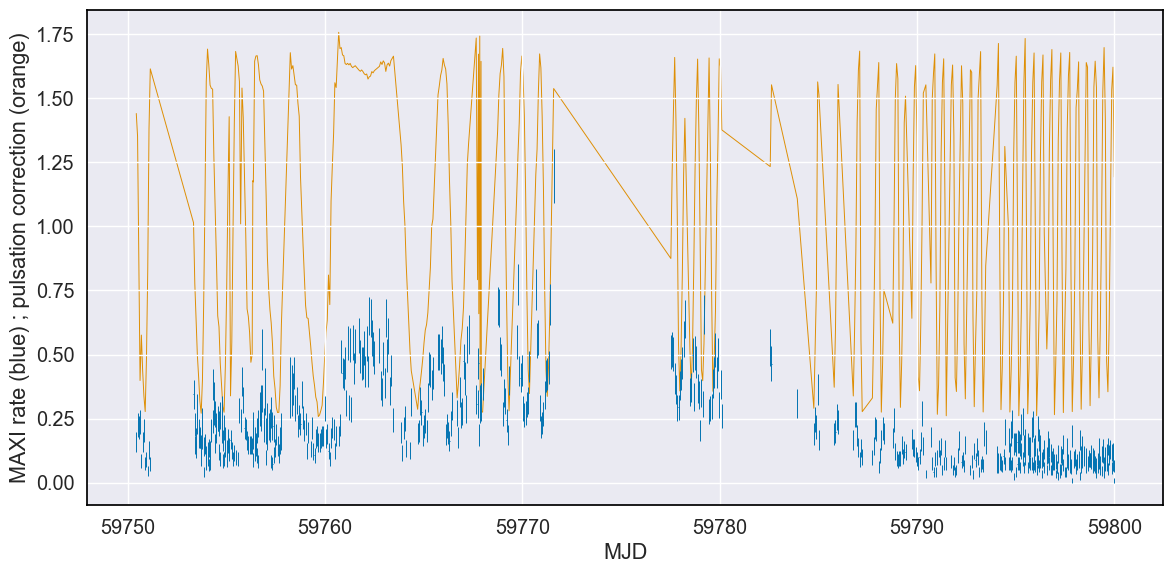

In [44]:
plt.figure(figsize=(12,6))
plt.errorbar(lc_MJD[interp_mask], (raw_lc['SCOUNT1']/raw_lc['EXPOSURE'])[interp_mask], yerr = (np.sqrt(raw_lc['SCOUNT1'])/raw_lc['EXPOSURE'])[interp_mask], xerr= lc_MJD_err[interp_mask], fmt='', ls='', lw=0.7)
plt.plot(lc_MJD[interp_mask], lc_pulse_corr, zorder=0, lw=0.7)
plt.ylabel('MAXI rate (blue) ; pulsation correction (orange)')
plt.xlabel('MJD')
plt.tight_layout()
plt.savefig(root_dir + 'figures/MAXI_pulse_correction.pdf')

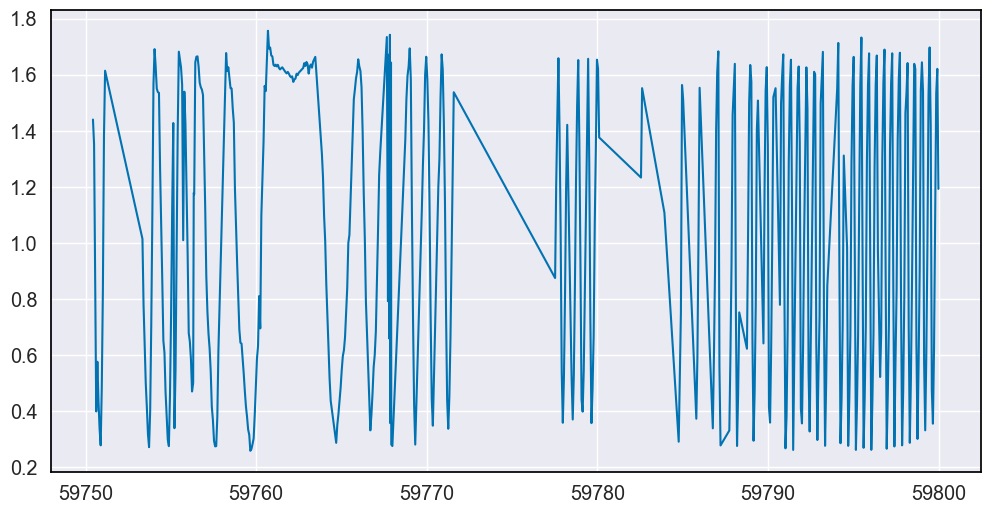

In [40]:
plt.figure(figsize=(12,6))
plt.plot(lc_MJD[interp_mask], lc_pulse_corr)